<a href="https://colab.research.google.com/github/sanyamjain789523/personalProjects/blob/main/Data_Science_Reaearch(enron_analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##LOADING csv file

import os, sys, email
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
import wordcloud

# Network analysis
import networkx as nx
# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output
print(check_output(["ls", "../input/enron-email-dataset/"]).decode("utf8"))

emails.csv



In [ ]:
#Read data into DataFrame
df = pd.read_csv('../input/enron-email-dataset/emails.csv')
print(df.shape)
df.head()

(517401, 2)


file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

In [ ]:
#Sample Email from the dataset
print(df['message'][3])

Message-ID: <13505866.1075863688222.JavaMail.evans@thyme>
Date: Mon, 23 Oct 2000 06:13:00 -0700 (PDT)
From: phillip.allen@enron.com
To: randall.gay@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Randall L Gay
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Randy,

 Can you send me a schedule of the salary and level of everyone in the 
scheduling group.  Plus your thoughts on any changes that need to be made.  
(Patti S for example)

Phillip


In [ ]:
##CLEANING data

#Create Helper functions (From Zichen Wang's Kernel: Explore Enron)
def get_text_from_email(msg):
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain': #extracting text data
            parts.append(part.get_payload())
    return ''.join(parts)

def split_email_adds(line): #splitting email addresses
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x : x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [ ]:
#create list of email objects
msgs = list(map(email.message_from_string, df['message']))
df.drop('message', axis=1, inplace=True) # axis = 1 used to apply a method across each row
# Get all fields from the email objects
fields = msgs[0].keys()
for field in fields:
    df[field] = [doc[field] for doc in msgs]
    
#parse content from emails
df['content'] = list(map(get_text_from_email, msgs))
# Split email address
df['From'] = df['From'].map(split_email_adds)
df['To'] = df['To'].map(split_email_adds)

#Extract the root of file as user
df['user'] = df['file'].map(lambda x:x.split('/')[0])
del msgs

df.head()

file                                     Message-ID  \
0     allen-p/_sent_mail/1.  <18782981.1075855378110.JavaMail.evans@thyme>   
1    allen-p/_sent_mail/10.  <15464986.1075855378456.JavaMail.evans@thyme>   
2   allen-p/_sent_mail/100.  <24216240.1075855687451.JavaMail.evans@thyme>   
3  allen-p/_sent_mail/1000.  <13505866.1075863688222.JavaMail.evans@thyme>   
4  allen-p/_sent_mail/1001.  <30922949.1075863688243.JavaMail.evans@thyme>   

                                    Date                       From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  (phillip.allen@enron.com)   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  (phillip.allen@enron.com)   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  (phillip.allen@enron.com)   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  (phillip.allen@enron.com)   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  (phillip.allen@enron.com)   

                          To    Subject Mime-Version  \
0     (tim.belden@enron.com)                     1.0   
1  (john.lavorato@enron.com)        Re:          1.0   
2   (leah.arsdall@enron.com)   Re: test          1.0   
3    (randall.gay@enron.com)                     1.0   
4     (greg.piper@enron.com)  Re: Hello          1.0   

                   Content-Type Content-Transfer-Encoding           X-From  \
0  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
1  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
2  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
3  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
4  text/plain; charset=us-ascii                      7bit  Phillip K Allen   

                                                X-To X-cc X-bcc  \
0           Tim Belden <Tim Belden/Enron@EnronXGate>              
1  John J Lavorato <John J Lavorato/ENRON@enronXg...              
2                                   Leah Van Arsdall              
3                                      Randall L Gay              
4                                         Greg Piper              

                                            X-Folder X-Origin  \
0  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
1  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
2    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
3    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
4    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   

                    X-FileName  \
0  pallen (Non-Privileged).pst   
1  pallen (Non-Privileged).pst   
2                   pallen.nsf   
3                   pallen.nsf   
4                   pallen.nsf   

                                             content     user  
0                          Here is our forecast\n\n   allen-p  
1  Traveling to have a business meeting takes the...  allen-p  
2                     test successful.  way to go!!!  allen-p  
3  Randy,\n\n Can you send me a schedule of the s...  allen-p  
4                Let's shoot for Tuesday at 11:45.    allen-p

In [ ]:
print(df.shape)
for col in df.columns:
    print(col, df[col].nunique())

(517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


In [ ]:
df = df.set_index('Message-ID')\
.drop(['file','Mime-Version','Content-Type', 'Content-Transfer-Encoding'], axis=1)
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format = True)
df.dtypes

Date          object
From          object
To            object
Subject       object
X-From        object
X-To          object
X-cc          object
X-bcc         object
X-Folder      object
X-Origin      object
X-FileName    object
content       object
user          object
dtype: object

In [ ]:
df['Date1'] = pd.to_datetime(df['Date'], errors='coerce',utc=True)

Text(0, 0.5, 'N emails')

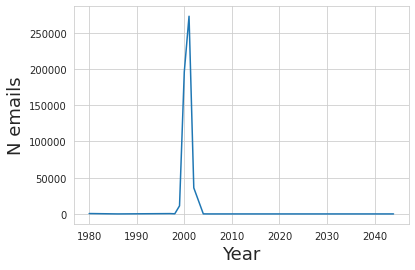

In [ ]:
ax = df.groupby(df['Date1'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

Text(0, 0.5, 'N emails')

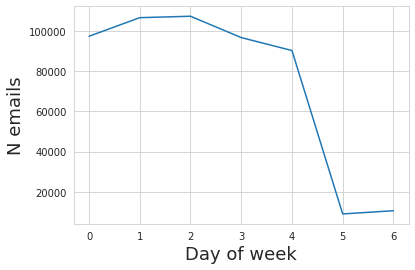

In [ ]:
ax = df.groupby(df['Date1'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

Text(0, 0.5, 'N emails')

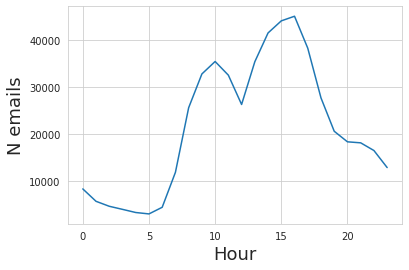

In [ ]:
ax = df.groupby(df['Date1'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

In [ ]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
df['subject_wc'] = df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
df['content_wc'] = df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [ ]:
grouped_by_people = df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()

N emails  Subject word count  Content word count
user                                                        
kaminski-v     28465            4.217530          255.906025
dasovich-j     28234            5.237373          603.393391
kean-s         25351            4.959331          490.837561
mann-k         23381            4.211796          207.195501
jones-t        19950            4.748221          185.462607

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning

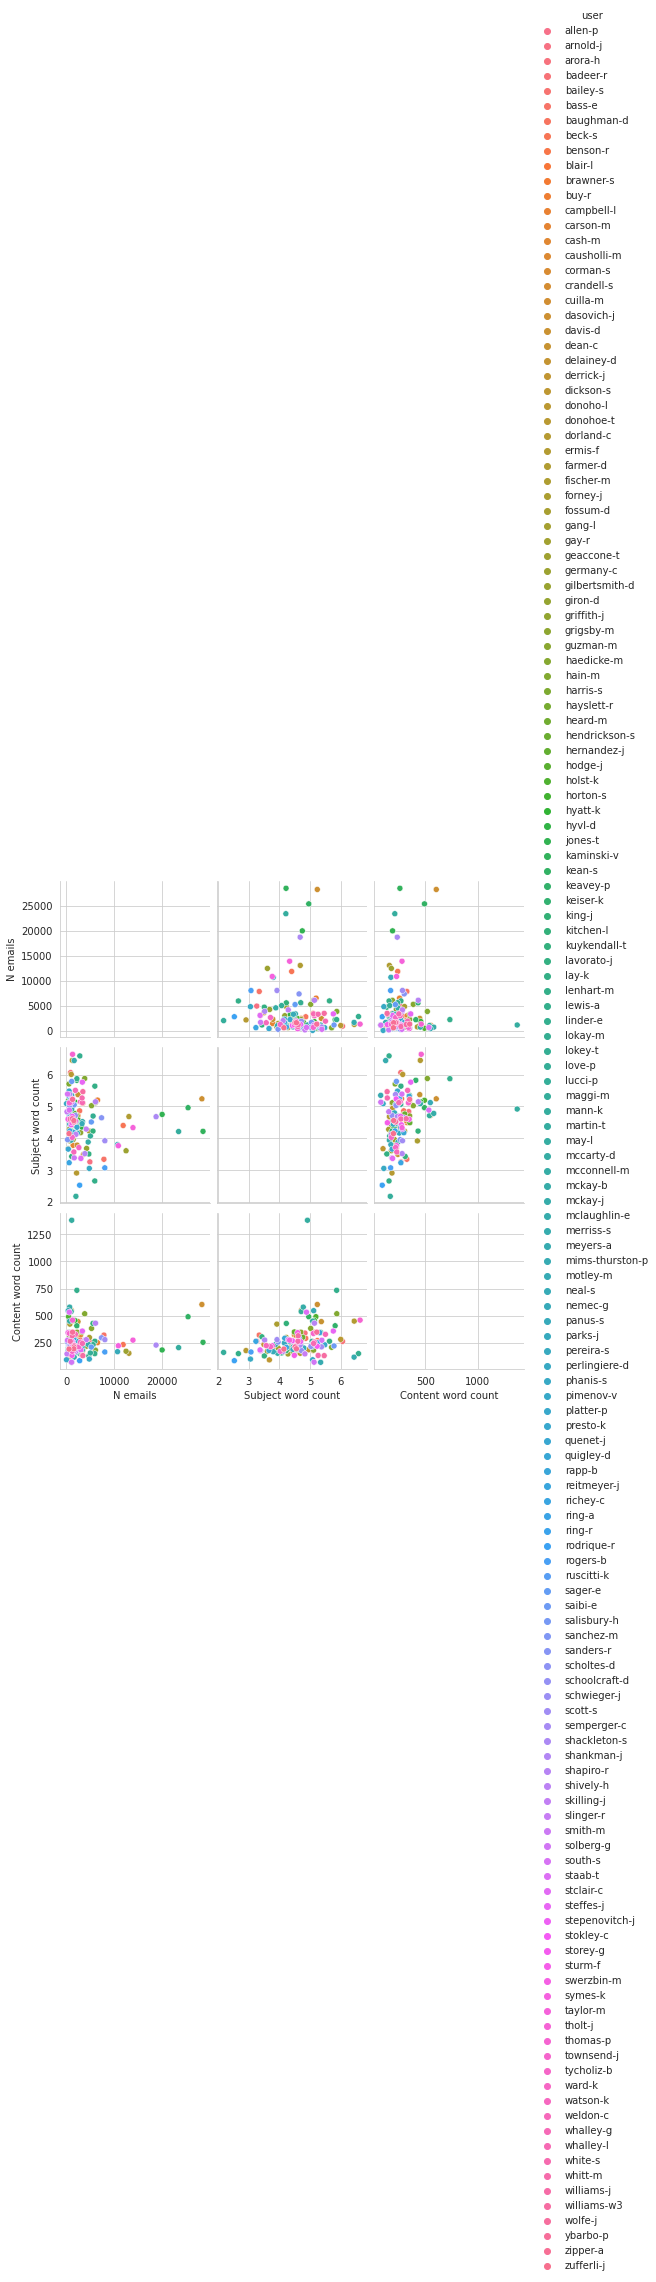

In [ ]:
sns.pairplot(grouped_by_people.reset_index(), hue='user')

In [ ]:
#Creating from_user list
userList = []
userList = df['user'].unique()

In [ ]:
#Number of emails sent by each users

count = []
counter = 0 
for l in userList:
    for user in df['user']:
        if user == l:
            counter += 1
    count.append(counter)
    counter = 0

[(28465, 'kaminski-v'), (28234, 'dasovich-j'), (25351, 'kean-s'), (23381, 'mann-k'), (19950, 'jones-t'), (18687, 'shackleton-s'), (13875, 'taylor-m'), (13032, 'farmer-d'), (12436, 'germany-c'), (11830, 'beck-s'), (10827, 'symes-k'), (10655, 'nemec-g'), (8022, 'scott-s'), (8009, 'rogers-b'), (7823, 'bass-e'), (7329, 'sanders-r'), (6490, 'campbell-l'), (6071, 'shapiro-r'), (6054, 'guzman-m'), (5937, 'lay-k')]


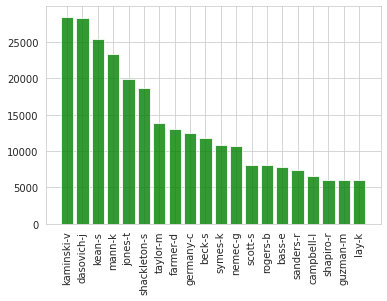

'The histogram shows users vs no. of emails they sent'

In [ ]:
'''Let us take a look at how many email were sent by each user. 
This plot may indicate erratic email usage. 
We plot top 20 users who sent the highest number of emails.'''

new_list = sorted(list(zip(count, userList)), reverse = True)[:20] ##merge both lists and sort top 20, 
print(new_list)
num, mailer = zip(*new_list) ## separate lists previously merged and use them for plotting
mail = range(len(new_list))
plt.bar(mail, num, align = 'center', color ='green', alpha=0.8)
plt.xticks(mail, mailer, rotation='vertical')
plt.show()

'''The histogram shows users vs no. of emails they sent'''

In [ ]:
#Read data into DataFrame
newdf = pd.read_csv('../input/year-vs-number-of-emails-enron-emails/part.csv')
print(newdf.shape)
newdf.head()

(481, 3)


user   year   emails
0  allen-p   1980       10
1  allen-p   1999        8
2  allen-p   2000     1307
3  allen-p   2001     1704
4  allen-p   2002        5

'The graph shows which user sent the most emails in which year.'

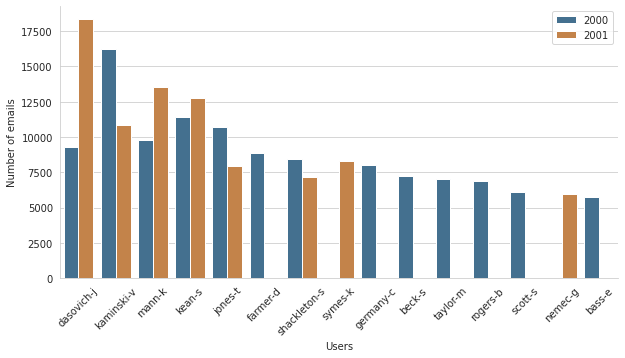

In [ ]:
#The dataset imported in the previous lines was extracted using MapReduce on CloudEra Hadoop Distribution 
#from the enron-email dataset. The new dataset retrieved as a result was uploaded to kaggle in the name of
#"year-vs-number-of-emails-enron-emails".
#The dataset includes three columns -
#User - name of the user
#Year - Year in which the user sent emails
#Emails - Number of emails sent by a particular user in a particular year.
#Using the data above, we will plot a graph to look for a user who sent the most emails around the time of the scam.'''
user = newdf["user"]
year = newdf[" year"]
emails = newdf[" emails"]
listnew = sorted(list(zip(emails, user, year)), reverse = True)[:21] ##merge both lists and sort top 15,
dframe = pd.DataFrame(listnew)
dframe.columns = ['emails', 'user', 'year']
dframe.head()
#The list 'listnew' contains top users with most emails sent"

#plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.barplot(x='user', y='emails', hue='year', data=dframe, saturation=0.5)
sns.despine()
plt.xticks(rotation=45)
plt.legend(loc='upper right')
fig.savefig('example.png')
plt.xlabel('Users')
plt.ylabel('Number of emails')


'''The graph shows which user sent the most emails in which year.'''

In [ ]:
dfs = df.sample(frac=1)

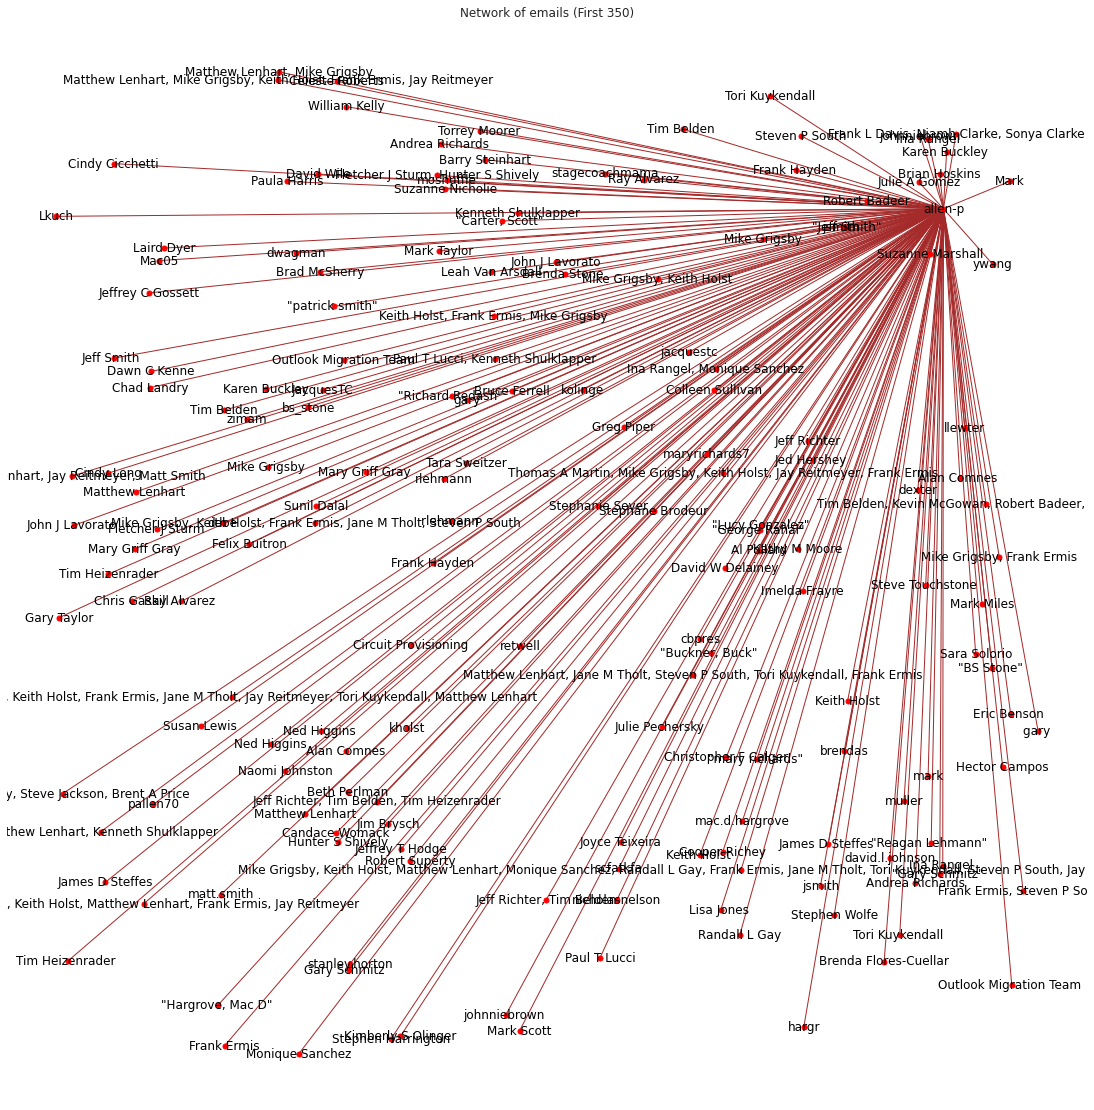

'In this graph, I attempted to visualize a network with users who sent and received emails as nodes. \nI chose to display only the first 350 emails because the graph looks clumsy with labels. \nFrom this graph, it can be noticed that the point of centrality is allen-p.'

In [ ]:
# The number of emails indicates a pattern,however it also important to consider the network
# that existed in the company.
dfnew = df.head(n=350)
# dfnew = dfs.head(n=350)

toUSER = []
for user in dfnew['X-To']:
    user = user.split('<')[0]
    user = user.split('@')[0]
    toUSER.append(user)
newlister = list(zip(dfnew['user'],toUSER))
datanewf = pd.DataFrame(newlister)
datanewf.columns = ['fromuser', 'touser']
G = nx.from_pandas_edgelist(datanewf, 'fromuser', 'touser')
plt.figure(figsize=(15,15))
pos = nx.draw_random(G, node_size = 25, node_color = 'red', edge_color = 'brown', with_labels = True)
plt.title('Network of emails (First 350)')
plt.show()

'''In this graph, I attempted to visualize a network with users who sent and received emails as nodes. 
I chose to display only the first 350 emails because the graph looks clumsy with labels. 
From this graph, it can be noticed that the point of centrality is allen-p.'''

In [ ]:
df.shape

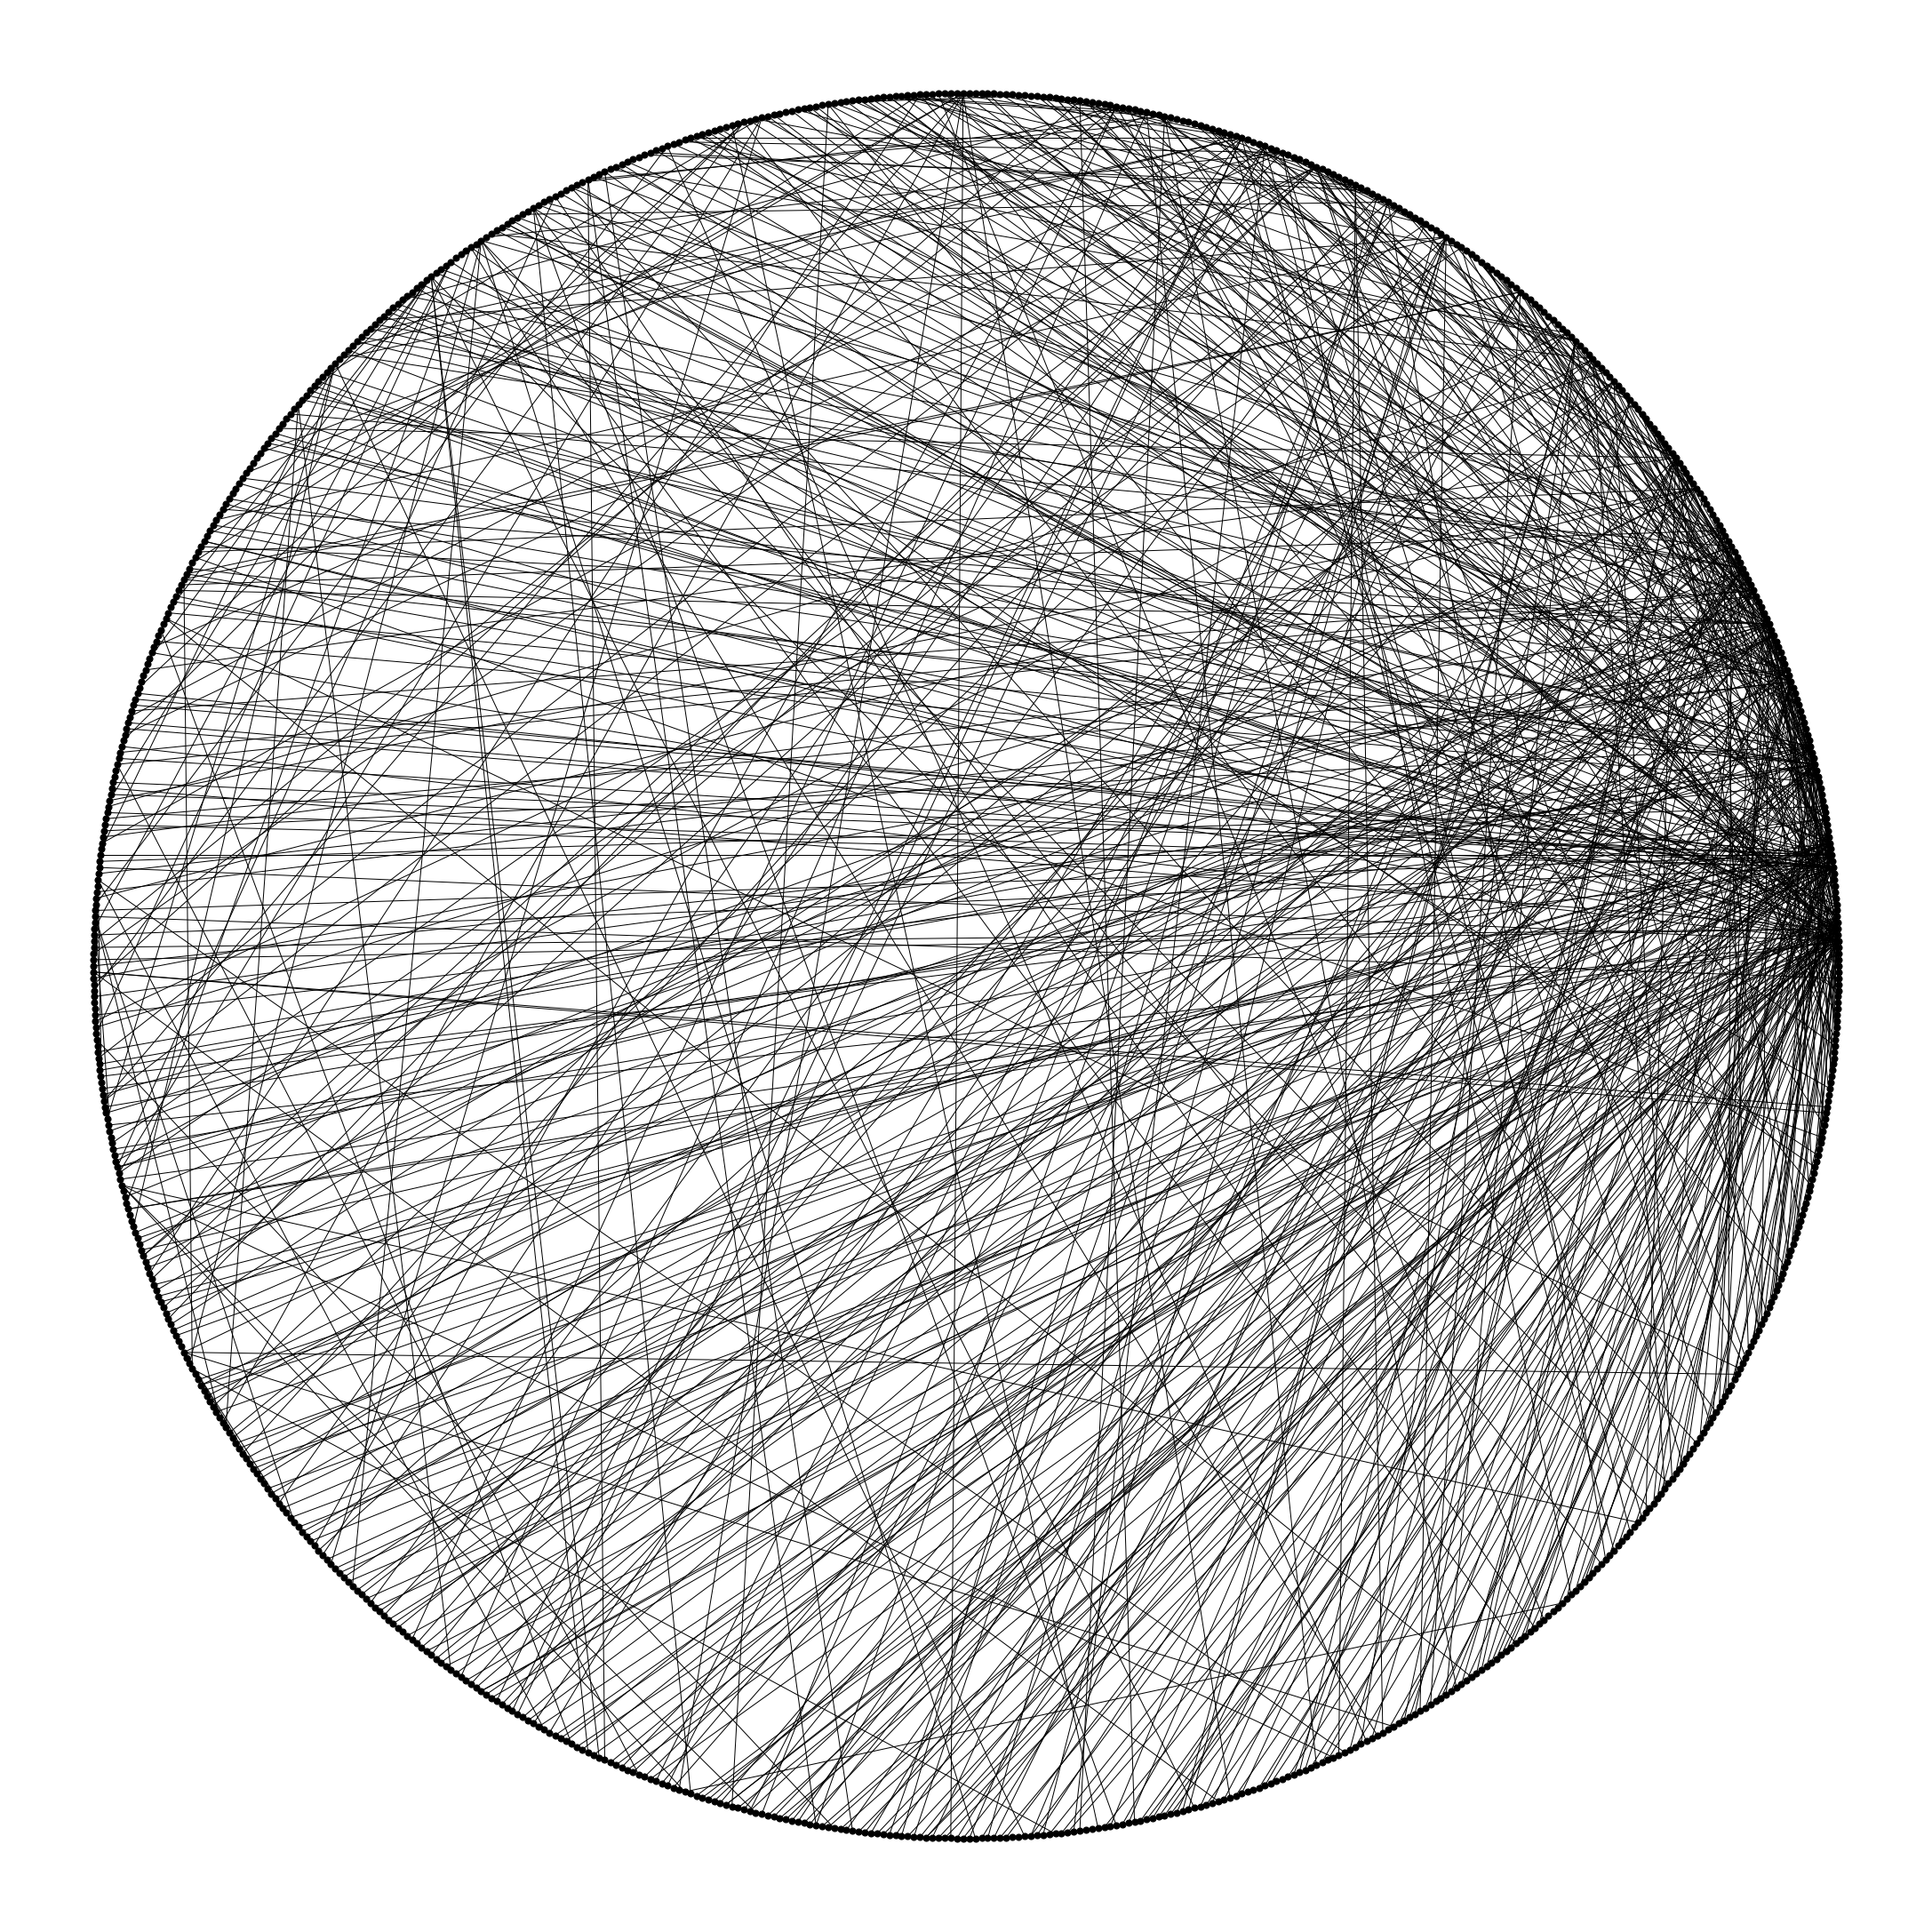

'The graph displays the network of first 1000 emails. The point of centrality is at node representing allen-p. \nTherefore, in this set of 1000 emails, the allen-p seems influential. However, this analysis is inaccurate as \nwe did not consider the total of 517000 emails.'

In [ ]:
# dfnew = df.head(n=10000)
dfnew = dfs.head(n=1000)

toUSER = []
for user in dfnew['X-To']:
    user = user.split('<')[0]
    user = user.split('@')[0]
    toUSER.append(user)
newlister = list(zip(dfnew['user'],toUSER))
datanewf = pd.DataFrame(newlister)
datanewf.columns = ['fromuser', 'touser']
G = nx.from_pandas_edgelist(datanewf, 'fromuser', 'touser')
plt.figure(figsize=(30,30))
pos = nx.draw_circular(G, node_size = 50, node_color = 'black', edge_color = 'black', with_labels = False)
plt.show()

'''The graph displays the network of first 1000 emails. The point of centrality is at node representing allen-p. 
Therefore, in this set of 1000 emails, the allen-p seems influential. However, this analysis is inaccurate as 
we did not consider the total of 517000 emails.'''

In [ ]:
# Read the data into a DataFrame
emails_df = pd.read_csv('../input/enron-email-dataset/emails.csv')
print(emails_df.shape)
emails_df.head()

In [ ]:
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [ ]:
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

In [ ]:
ax = df.groupby(df['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)